In [ ]:
!pip install surprise

In [1]:
from google.cloud import bigquery
import pandas as pd

PROJECT = "students-group3"
client = bigquery.Client(project=PROJECT)

query = """
SELECT *
FROM `master-ai-cloud.MoviePlatform.ratings`
"""


df1 = client.query(query).to_dataframe()
print(df1.tail())

        userId  movieId  rating   timestamp
105334     668    93040     5.0  1331051757
105335     668    98154     5.0  1353208964
105336     668   101862     5.0  1373168467
105337     668   106916     5.0  1388740601
105338     668   116136     5.0  1415763726


In [2]:
from google.cloud import bigquery
import pandas as pd

PROJECT = "students-group3"
client = bigquery.Client(project=PROJECT)

query = """
SELECT *
FROM `master-ai-cloud.MoviePlatform.movies`
"""


df2 = client.query(query).to_dataframe()
print(df2.tail())

       movieId                        title   genres
10324    85896  Tribute to a Bad Man (1956)  Western
10325   103570     Dead Man's Burden (2012)  Western
10326   105223    Colorado Territory (1949)  Western
10327   128360     The Hateful Eight (2015)  Western
10328   128695       The Dark Valley (2014)  Western


In [3]:
df = pd.merge(df1, df2, on="movieId", how="left")


In [4]:
df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,204,0.5,1217895786,Under Siege 2: Dark Territory (1995),Action
1,1,256,0.5,1217895764,Junior (1994),Comedy|Sci-Fi
2,1,277,0.5,1217895772,Miracle on 34th Street (1994),Drama
3,1,719,0.5,1217895799,Multiplicity (1996),Comedy
4,1,45950,0.5,1217897813,"Inconvenient Truth, An (2006)",Documentary


In [5]:
df.isna().sum()


userId       0
movieId      0
rating       0
timestamp    0
title        0
genres       0
dtype: int64

In [7]:
df.describe()

,userId,movieId,rating,timestamp
count,105339.0,105339.0,105339.000000,105339.0
mean,364.924539,13381.312477,3.516850,1130423971.974255
std,197.486905,26170.456869,1.044872,180266031.941075
min,1.0,1.0,0.500000,828564954.0
25%,192.0,1073.0,3.000000,971100797.5
50%,383.0,2497.0,3.500000,1115154056.0
75%,557.0,5991.0,4.000000,1275495998.5
max,668.0,149532.0,5.000000,1452404919.0


In [6]:
df.to_csv("movies_merged.csv", index=False)


In [8]:
df.duplicated().sum()

0

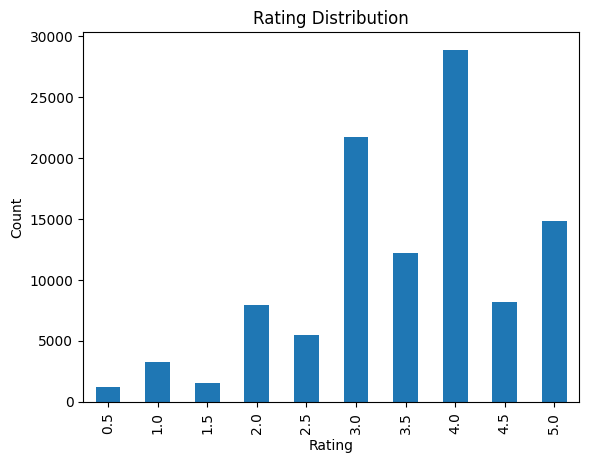

In [9]:
import matplotlib.pyplot as plt

df['rating'].value_counts().sort_index().plot(kind='bar')
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Rating Distribution")
plt.show()


In [10]:
df["genres"].nunique()


938

In [11]:
df1['genres'] = df['genres'].str.split('|')

genres_exploded = df1.explode('genres')
genre_counts = genres_exploded['genres'].value_counts()

genre_counts.head(10)

genres
Drama        46960
Comedy       38055
Action       31205
Thriller     29288
Adventure    23076
Romance      19094
Crime        18291
Sci-Fi       16795
Fantasy      10889
Mystery       8320
Name: count, dtype: int64

In [12]:
df.drop(columns="timestamp")

,userId,movieId,rating,title,genres
0,1,204,0.5,Under Siege 2: Dark Territory (1995),Action
1,1,256,0.5,Junior (1994),Comedy|Sci-Fi
2,1,277,0.5,Miracle on 34th Street (1994),Drama
3,1,719,0.5,Multiplicity (1996),Comedy
4,1,45950,0.5,"Inconvenient Truth, An (2006)",Documentary
...,...,...,...,...,...
105334,668,93040,5.0,"Civil War, The (1990)",Documentary|War
105335,668,98154,5.0,Lincoln (2012),Drama|War
105336,668,101862,5.0,50 Children: The Rescue Mission of Mr. And Mrs...,Documentary
105337,668,106916,5.0,American Hustle (2013),Crime|Drama


In [13]:
df["title"].nunique()


10323

In [14]:
from sklearn.preprocessing import MultiLabelBinarizer

df['genres_list'] = df['genres'].str.split('|')

mlb = MultiLabelBinarizer()
genre_matrix = mlb.fit_transform(df['genres_list'])
movie_genres = {movie_id: genre_matrix[i] for i, movie_id in enumerate(df['movieId'].unique())}


In [16]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
movie_genres = {row['movieId']: np.array(mlb.transform([row['genres_list']])[0]) for idx, row in df.drop_duplicates('movieId').iterrows()}



In [17]:
train_df = df[["userId", "movieId", "rating"]]

In [18]:
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split

reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(train_df, reader)

trainset, testset = train_test_split(
    data, test_size=0.2, random_state=42
)

In [19]:
from surprise import SVD

model = SVD(
    n_factors=100,
    n_epochs=30,
    lr_all=0.005,
    reg_all=0.02,
    random_state=42
)

In [20]:
model.fit(trainset)

In [21]:
from surprise import accuracy

predictions = model.test(testset)
rmse = accuracy.rmse(predictions)

RMSE: 0.8859


In [22]:
accuracy.mae(predictions)

MAE:  0.6823


0.6822676927122745

In [23]:
full_trainset = data.build_full_trainset()
model.fit(full_trainset)

In [24]:
predictions = model.test(testset)
rmse = accuracy.rmse(predictions)

RMSE: 0.7290


In [25]:
accuracy.mae(predictions)

MAE:  0.5449


0.5448790463194811

In [26]:
from surprise.model_selection import GridSearchCV

param_grid = {
    'n_factors': [50, 100, 150],
    'n_epochs': [20, 30],
    'lr_all': [0.002, 0.005],
    'reg_all': [0.02, 0.05]
}

gs = GridSearchCV(
    SVD,
    param_grid,
    measures=['rmse'],
    cv=3,
    n_jobs=-1
)

gs.fit(data)

print(gs.best_score['rmse'])
print(gs.best_params['rmse'])


0.864801279718308
{'n_factors': 50, 'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.05}


In [27]:
best_svd = SVD(**gs.best_params['rmse'])
best_svd.fit(data.build_full_trainset())


In [28]:
def genre_similarity(candidate_movie_id, rated_movies):
    candidate_vec = movie_genres[candidate_movie_id].reshape(1, -1)
    rated_vecs = np.array([movie_genres[m] for m in rated_movies])
    
    if len(rated_vecs) == 0:
        return 0  # cold-start user
    
    # cosine similarity with all rated movies
    sims = cosine_similarity(candidate_vec, rated_vecs)
    return sims.mean()

In [ ]:
def hybrid_recommend(model, df, user_id, k=10, alpha=0.7):
    all_movies = df['movieId'].unique()
    rated_movies = df[df['userId'] == user_id]['movieId'].values
    movies_to_predict = np.setdiff1d(all_movies, rated_movies)
    
    results = []
    
    for movie_id in movies_to_predict:
        # CF score
        cf_score = model.predict(user_id, movie_id).est
        
        # Genre score
        genre_score = genre_similarity(movie_id, rated_movies)
        
        # Hybrid score
        final_score = alpha * cf_score + (1 - alpha) * genre_score * 5  # scale to 0-5
        
        movie_row = df[df['movieId'] == movie_id].iloc[0]
        results.append({
            "movieId": movie_id,
            "title": movie_row['title'],
            "genres": movie_row['genres'],
            "hybrid_score": round(final_score, 2)
        })
        results.sort(key=lambda x: x['hybrid_score'], reverse=True)
    
    return results[:k]


In [40]:
"""import numpy as np
def recommend_movies(model, df, user_id, k=10):
    all_movies = df['movieId'].unique()
    rated_movies = df[df['userId'] == user_id]['movieId'].values
    
    movies_to_predict = np.setdiff1d(all_movies, rated_movies)
    
    predictions = [
        (movie, model.predict(user_id, movie).est)
        for movie in movies_to_predict
    ]
    
    predictions.sort(key=lambda x: x[1], reverse=True)
    top_k = predictions[:k]
    
    return top_k
"""

In [52]:
"""user_id = 100
recommendations = recommend_movies(best_svd, df, user_id, k=5)

for movie_id, score in recommendations:
    movie_row = df[df['movieId'] == movie_id].iloc[0]
    title = movie_row['title']
    genres = movie_row['genres']
    
    print(f"{title} | Genres: {genres} → predicted rating: {score:.2f}")"""

Shawshank Redemption, The (1994) | Genres: Crime|Drama → predicted rating: 4.22
Kolya (Kolja) (1996) | Genres: Comedy|Drama → predicted rating: 4.21
Third Man, The (1949) | Genres: Film-Noir|Mystery|Thriller → predicted rating: 4.20
Harold and Maude (1971) | Genres: Comedy|Drama|Romance → predicted rating: 4.20
Paths of Glory (1957) | Genres: Drama|War → predicted rating: 4.19


In [33]:
user_id = 50
top_hybrid = hybrid_recommend(best_svd, df, user_id, k=5, alpha=0.7)

for rec in top_hybrid:
    print(f"{rec['title']} | Genres: {rec['genres']} → hybrid score: {rec['hybrid_score']}")


Sweet Hereafter, The (1997) | Genres: Drama → hybrid score: 3.42
Cat on a Hot Tin Roof (1958) | Genres: Drama → hybrid score: 3.39
Smoke (1995) | Genres: Comedy|Drama → hybrid score: 3.31
Kolya (Kolja) (1996) | Genres: Comedy|Drama → hybrid score: 3.29
Dallas Buyers Club (2013) | Genres: Drama → hybrid score: 3.29


In [34]:
df2=df[df["userId"]==50]

In [35]:
df2.sort_values(by='rating', ascending=False)

,userId,movieId,rating,timestamp,title,genres,genres_list
91275,50,1394,5.0,905248257,Raising Arizona (1987),Comedy,[Comedy]
91274,50,1237,5.0,905248992,"Seventh Seal, The (Sjunde inseglet, Det) (1957)",Drama,[Drama]
91273,50,1228,5.0,905247974,Raging Bull (1980),Drama,[Drama]
91272,50,1219,5.0,904745375,Psycho (1960),Crime|Horror,"[Crime, Horror]"
91271,50,778,5.0,905248796,Trainspotting (1996),Comedy|Crime|Drama,"[Comedy, Crime, Drama]"
...,...,...,...,...,...,...,...
1321,50,1183,1.0,893082515,"English Patient, The (1996)",Drama|Romance|War,"[Drama, Romance, War]"
1326,50,1885,1.0,904747787,"Opposite of Sex, The (1998)",Comedy|Drama|Romance,"[Comedy, Drama, Romance]"
1327,50,1921,1.0,904743413,Pi (1998),Drama|Sci-Fi|Thriller,"[Drama, Sci-Fi, Thriller]"
1328,50,2263,1.0,905247974,"Seventh Sign, The (1988)",Drama|Fantasy|Thriller,"[Drama, Fantasy, Thriller]"
